In [1]:
import os
import pandas as pd
from functools import reduce

folder = "./archivos"  # Cambia si tus archivos están en otra carpeta

# Listar archivos CSV que NO contengan 'combinado' ni 'todos_los_productos_unificados'
csvs = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".csv") and "combinado" not in f and "todos_los_productos_unificados" not in f]
if not csvs:
    raise ValueError("No se encontraron archivos CSV válidos en la carpeta especificada.")
print(f"Archivos CSV encontrados: {len(csvs)}")
csvs.sort()

# Leer y renombrar 'tn' de cada archivo
dfs = []
for csv_path in csvs:
    nombre = os.path.splitext(os.path.basename(csv_path))[0]
    df = pd.read_csv(csv_path)
    if 'tn' in df.columns:
        df = df[['product_id', 'tn']].copy()
        df.rename(columns={'tn': f'tn_{nombre}'}, inplace=True)
        dfs.append(df)
    else:
        print(f"Advertencia: {csv_path} no tiene columna 'tn'. Se ignora.")

# Merge iterativo por product_id con INNER JOIN
df_merged = reduce(lambda left, right: pd.merge(left, right, on='product_id', how='inner'), dfs)

# Guardar resultado
output = os.path.join(folder, "todos_los_productos_unificados.csv")
df_merged.to_csv(output, index=False)
print(f"Archivo generado: {output}")


Archivos CSV encontrados: 5
Archivo generado: ./archivos/todos_los_productos_unificados.csv


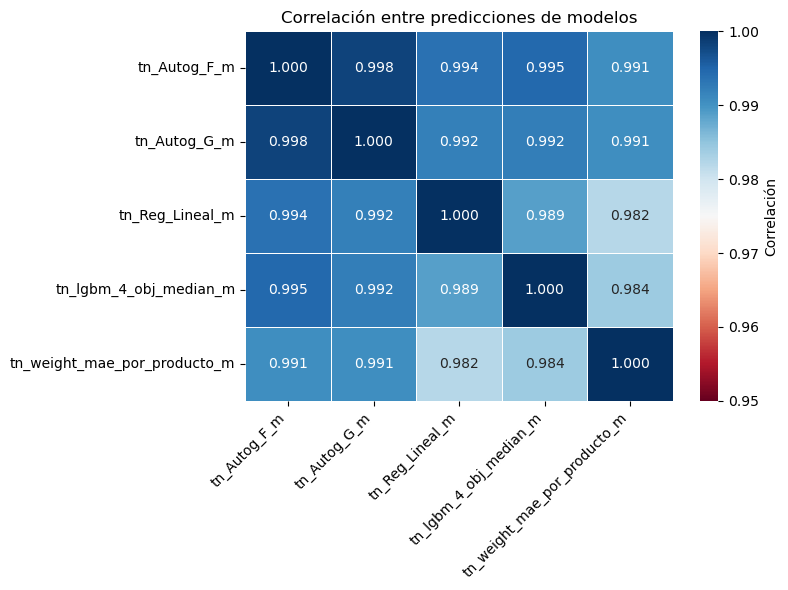


Top 5 pares más parecidos:
Autog_F_m                  ↔  Autog_G_m                  correlación: 0.9982
Autog_F_m                  ↔  lgbm_4_obj_median_m        correlación: 0.9946
Autog_F_m                  ↔  Reg_Lineal_m               correlación: 0.9936
Autog_G_m                  ↔  lgbm_4_obj_median_m        correlación: 0.9922
Autog_G_m                  ↔  Reg_Lineal_m               correlación: 0.9920

Top 5 pares menos parecidos:
Autog_F_m                  ↔  weight_mae_por_producto_m  correlación: 0.9906
Autog_G_m                  ↔  weight_mae_por_producto_m  correlación: 0.9905
Reg_Lineal_m               ↔  lgbm_4_obj_median_m        correlación: 0.9888
lgbm_4_obj_median_m        ↔  weight_mae_por_producto_m  correlación: 0.9840
Reg_Lineal_m               ↔  weight_mae_por_producto_m  correlación: 0.9821


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Matriz de correlación
tn_cols = [col for col in df_merged.columns if col.startswith('tn_')]
corr_matrix = df_merged[tn_cols].corr()

# Heatmap bonito
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap="RdBu", vmin=0.95, vmax=1.0, 
            linewidths=.5, cbar_kws={'label': 'Correlación'})
plt.title("Correlación entre predicciones de modelos")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Lista de pares (sin duplicados ni diagonal)
corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Flatten y ordenar
pairs = []
for i in range(len(tn_cols)):
    for j in range(i+1, len(tn_cols)):
        pairs.append( (tn_cols[i], tn_cols[j], corr_matrix.iloc[i,j]) )
# Ordenar de más parecido a menos
pairs_sorted = sorted(pairs, key=lambda x: -x[2])

print("\nTop 5 pares más parecidos:")
for a, b, v in pairs_sorted[:5]:
    print(f"{a.replace('tn_',''):25s}  ↔  {b.replace('tn_',''):25s}  correlación: {v:.4f}")

print("\nTop 5 pares menos parecidos:")
for a, b, v in pairs_sorted[-5:]:
    print(f"{a.replace('tn_',''):25s}  ↔  {b.replace('tn_',''):25s}  correlación: {v:.4f}")


In [3]:
import itertools
import numpy as np

# tn_cols y corr_matrix ya los tenés definidos por tu código
# tn_cols = [col for col in df_merged.columns if col.startswith('tn_')]
# corr_matrix = df_merged[tn_cols].corr()

promedios_de_tres = []
for trio in itertools.combinations(tn_cols, 3):
    # Calcular correlaciones entre los tres pares posibles del trío
    corr1 = corr_matrix.loc[trio[0], trio[1]]
    corr2 = corr_matrix.loc[trio[0], trio[2]]
    corr3 = corr_matrix.loc[trio[1], trio[2]]
    promedio = np.mean([corr1, corr2, corr3])
    promedios_de_tres.append((trio, promedio))

# Ordenar de mayor a menor correlación promedio
promedios_de_tres.sort(key=lambda x: -x[1])

print("Promedios de correlación (de a 3 modelos):")
for trio, prom in promedios_de_tres:
    print(f"{trio}: promedio correlación = {prom:.4f}")


Promedios de correlación (de a 3 modelos):
('tn_Autog_F_m', 'tn_Autog_G_m', 'tn_lgbm_4_obj_median_m'): promedio correlación = 0.9950
('tn_Autog_F_m', 'tn_Autog_G_m', 'tn_Reg_Lineal_m'): promedio correlación = 0.9946
('tn_Autog_F_m', 'tn_Autog_G_m', 'tn_weight_mae_por_producto_m'): promedio correlación = 0.9931
('tn_Autog_F_m', 'tn_Reg_Lineal_m', 'tn_lgbm_4_obj_median_m'): promedio correlación = 0.9923
('tn_Autog_G_m', 'tn_Reg_Lineal_m', 'tn_lgbm_4_obj_median_m'): promedio correlación = 0.9910
('tn_Autog_F_m', 'tn_lgbm_4_obj_median_m', 'tn_weight_mae_por_producto_m'): promedio correlación = 0.9897
('tn_Autog_G_m', 'tn_lgbm_4_obj_median_m', 'tn_weight_mae_por_producto_m'): promedio correlación = 0.9889
('tn_Autog_F_m', 'tn_Reg_Lineal_m', 'tn_weight_mae_por_producto_m'): promedio correlación = 0.9887
('tn_Autog_G_m', 'tn_Reg_Lineal_m', 'tn_weight_mae_por_producto_m'): promedio correlación = 0.9882
('tn_Reg_Lineal_m', 'tn_lgbm_4_obj_median_m', 'tn_weight_mae_por_producto_m'): promedio corr

In [4]:
# Combinar lgbm_4_objectives_median_m, weight_mae_por_producto_m y Reg_Lineal_m por media y y guardar desde el dataframe df_merged
selected_models = ['tn_lgbm_4_obj_median_m', 'tn_weight_mae_por_producto_m', 'tn_Reg_Lineal_m']
output_file = os.path.join(folder, "combinado_sin_ajustar_lgbm_4_objectives_median_weight_mae_por_producto_Reg_Lineal.csv")
df_combined = df_merged[['product_id'] + selected_models].copy()
df_combined['tn'] = df_combined[selected_models].mean(axis=1)
df_combined = df_combined[['product_id', 'tn']]
df_combined.to_csv(output_file, index=False)
print(f"Archivo combinado guardado: {output_file}")


Archivo combinado guardado: ./archivos/combinado_sin_ajustar_lgbm_4_objectives_median_weight_mae_por_producto_Reg_Lineal.csv
